In [1]:
import os
import sys
import boto3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from dotenv import load_dotenv

# defining functions module path
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import connect_to_redshift

In [2]:
# removing warning messages
warnings.filterwarnings("ignore")

In [3]:
# Loading my .env file
load_dotenv()

True

In [4]:
# defining redshift credentials
dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

In [5]:
# establishing redshift connection
rs_connection = connect_to_redshift(dbname, host, port, user, password)

connection to redshift made


In [6]:
query = """select *
           from bootcamp.online_transactions_fixed
        """

In [7]:
ot = pd.read_sql(query, rs_connection)

In [8]:
print(f"There are {ot.duplicated().sum()} duplicated rows in the dataset")

There are 0 duplicated rows in the dataset


In [9]:
ot.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,total_order_value
0,536373,82494L,WOODEN FRAME ANTIQUE WHITE,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30
1,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95
2,536381,22438,BALLOON ART MAKE YOUR OWN FLOWERS,1,2010-12-01 09:41:00,1.95,u15311,United Kingdom,1.95
3,536384,22189,CREAM HEART CARD HOLDER,4,2010-12-01 09:53:00,3.95,u18074,United Kingdom,15.80
4,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,6,2010-12-01 10:03:00,5.45,u12431,Australia,32.70


In [10]:
print(ot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399841 entries, 0 to 399840
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   invoice            399841 non-null  object        
 1   stock_code         399841 non-null  object        
 2   description        399841 non-null  object        
 3   quantity           399841 non-null  int64         
 4   invoice_date       399841 non-null  datetime64[ns]
 5   price              399841 non-null  float64       
 6   customer_id        399841 non-null  object        
 7   country            399841 non-null  object        
 8   total_order_value  399841 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 27.5+ MB
None


In [11]:
ot.describe()

,quantity,price,total_order_value
count,399841.000000,399841.000000,399841.000000
mean,12.224359,2.952914,20.716904
std,250.788860,7.317593,425.471765
min,-80995.000000,0.000000,-168469.600000
25%,2.000000,1.250000,4.250000
50%,5.000000,1.950000,11.580000
75%,12.000000,3.750000,19.500000
max,80995.000000,1599.260000,168469.600000


In [12]:
ot.describe(include=object)

,invoice,stock_code,description,customer_id,country
count,399841,399841,399841,399841,399841
unique,21791,3679,3644,4363,37
top,576339,85123A,CREAM HANGING HEART T-LIGHT HOLDER,u17841,United Kingdom
freq,542,2065,2065,7800,356158


### Let's explore the outliers

<Axes: >

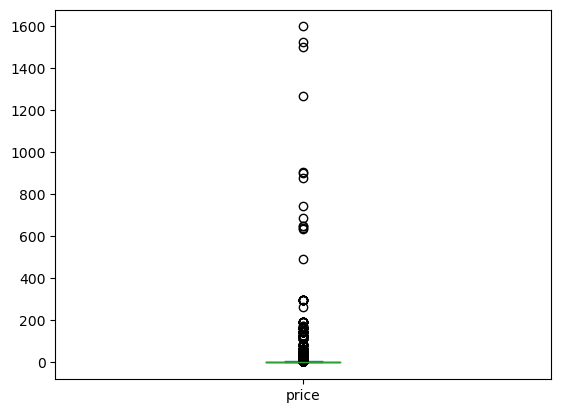

In [13]:
ot['price'].plot.box()

### It is clear that there are outliers on the price column. Let's check how many transactions are with price equal to zero

In [14]:
# Number of transactions with price equal to zero
n_price_zero = ot[ot['price'] == 0].shape[0]
print(f"There are {n_price_zero} transactions with price zero. That represents {round(n_price_zero * 100 / ot.shape[0], 2)} % of the data, therefore they are gonna be removed from the dataset.")

There are 34 transactions with price zero. That represents 0.01 % of the data, therefore they are gonna be removed from the dataset.


In [15]:
ot.drop(ot[ot['price'] == 0].index, axis=0, inplace=True)
ot.reset_index(inplace=True, drop=True)

In [16]:
# Let's start by exploring the outliers in the price column
_, mean_price, std_price, min_price, Q1_price, Q2_price, Q3_price, max_price = ot.price.describe()
IQR_price = Q3_price - Q1_price
low_lim_price = Q1_price - 1.5 * IQR_price
up_lim_price = Q3_price + 1.5 * IQR_price

Text(0.5, 23.52222222222222, 'Price (pounds)')

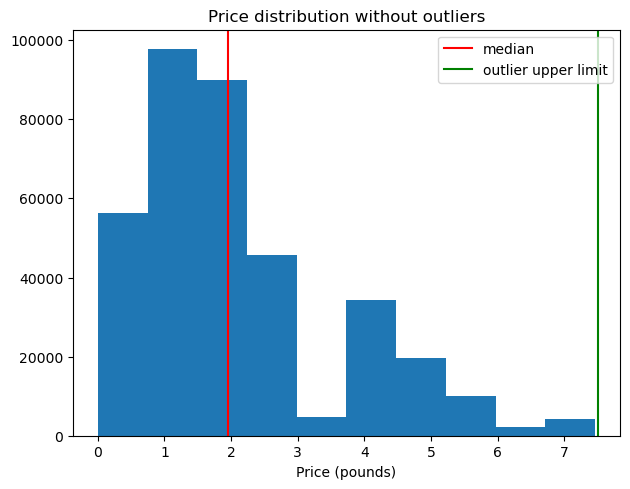

In [17]:
# Price histogram plotting
plt.hist(ot.price[ot['price'] < up_lim_price])
plt.axvline(x=Q2_price, color='red', label='median')
plt.axvline(x=up_lim_price, color='green', label='outlier upper limit')
plt.title("Price distribution without outliers")
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlabel('Price (pounds)')

In [18]:
outlier_perc = round(ot[ot['price'] >= up_lim_price].shape[0] * 100 / ot.shape[0], 2)
print(f"{outlier_perc} % of my data are outliers on the price variable")

8.75 % of my data are outliers on the price variable


## To appling the k-means to segment my data I must handle the outliers because they affect the centroids' calculation from the method

### Let's explore seasonality in the data

In [19]:
# Setting up monthly, yearly, daily data
ot['invoice_year'] = ot['invoice_date'].dt.year
ot['invoice_month'] = ot['invoice_date'].dt.month
ot['invoice_weekday'] = ot['invoice_date'].dt.dayofweek
ot['invoice_dayname'] = ot['invoice_date'].dt.day_name()

In [20]:
# Defining color palette for plots
palette = sns.color_palette("tab10")

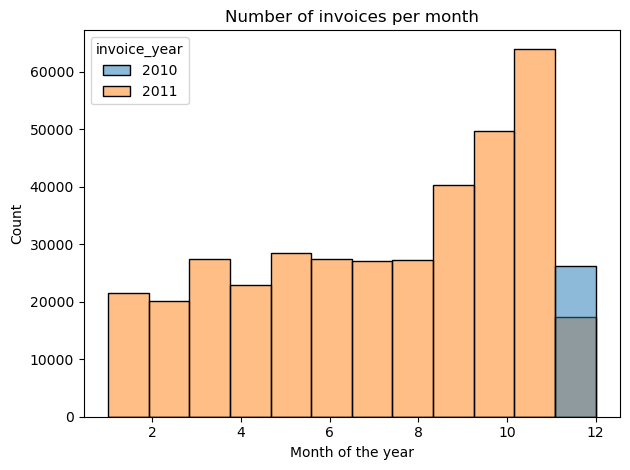

In [21]:
# Distribution of invoices per month
sns.histplot(data=ot, x='invoice_month', hue='invoice_year', bins=12, kde=False, palette=palette)
plt.title("Number of invoices per month")
plt.xlabel("Month of the year")
plt.tight_layout()
plt.savefig("../visualizations/invoice_month.png")

### The number of invoice has a boost from September on, having a peak on November (presumably because of Black Friday) reachig its lowest point on December 2011.

In [22]:
# To plot the days in order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ot['invoice_dayname'] = pd.Categorical(ot['invoice_date'].dt.day_name(), categories=day_order, ordered=True)

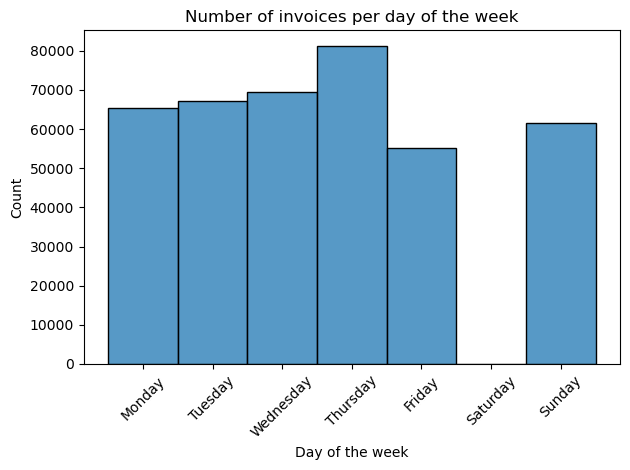

In [23]:
# Distributions of invoices per day of the week
sns.histplot(data=ot, x='invoice_dayname', multiple='stack', bins=12, kde=False)
plt.title("Number of invoices per day of the week")
plt.xlabel("Day of the week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../visualizations/invoice_weekday.png")

In [24]:
ot['invoice_dayname'].unique()

['Wednesday', 'Thursday', 'Friday', 'Sunday', 'Monday', 'Tuesday']
Categories (7, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday' < 'Sunday']

### The number of invoice has a peak on Thursdays. It is interesting that there is no data available for Saturdays

## Let's explore some KPIs

In [25]:
# Line Items (Number of products per invoice)
line_items = ot.groupby("invoice")['stock_code'].count()
print(f"On average, there are {round(line_items.mean())} stock codes per invoice")

On average, there are 18 stock codes per invoice


In [26]:
# Average order value per invoice
avg_order = ot.groupby("invoice").sum()['total_order_value']
print(f"The average purchase per invoice is {round(avg_order.mean(), 2)} pounds")

The average purchase per invoice is 380.18 pounds


In [27]:
# Average order value per customer
cust_spent = ot.groupby("customer_id").sum()['total_order_value']
print(f"In average the customer spent {round(cust_spent.mean(),2)} pounds from December 2010 to December 2011")

In average the customer spent 1899.01 pounds from December 2010 to December 2011


In [28]:
# Number of customers who spent more than the average
cust_above_avg = (cust_spent > cust_spent.mean()).sum() 
print(f"There are {cust_above_avg} customers (out of {ot['customer_id'].nunique()}) who spent more than the average customers")

There are 901 customers (out of 4362) who spent more than the average customers


In [29]:
# Average invoices per customer
inv_cust = ot.groupby('customer_id').count()['invoice']
print(f"The customers made on average {round(inv_cust.mean())} purchases")

The customers made on average 92 purchases


In [30]:
# How many customers are above the average invoice per customer?
print(f"There are {(inv_cust > inv_cust.mean()).sum()} customers who made more purchases than the average")

There are 1192 customers who made more purchases than the average


In [31]:
# filtering the data by month and year
idx_month_year = (ot['invoice_month'] == 11) & (ot['invoice_year'] == 2011) 
ot[idx_month_year].groupby("customer_id").agg({'invoice': 'count', 'stock_code': 'nunique'}).sort_values(by='invoice', ascending=False)

,invoice,stock_code
customer_id,,
u14096,1894,836
u12748,1598,885
u17841,1369,579
u14911,937,568
u16549,502,303
...,...,...
u14235,1,1
u1808,1,1
u14292,1,1


### For the top 5 customers/products check the purchases on time.

### Let's explore the data grouped by customer

In [32]:
cust_data = pd.DataFrame()
cust_group = ot.groupby('customer_id')

In [33]:
# Let's define customer loyalty as the difference in time between the 1st and the last purchase
delta_date = (ot.groupby('customer_id').first()['invoice_date'] - ot.groupby('customer_id').last()['invoice_date']).abs()
cust_data['loyalty_time'] = delta_date.dt.days

In [34]:
once_cust = cust_data[cust_data['loyalty_time'] == 0].shape[0]
print(f"There are {once_cust} customer with less than 1 day of loyalty. This represent {round(once_cust *100 / cust_data.shape[0])}% of the total clients")

There are 1559 customer with less than 1 day of loyalty. This represent 36% of the total clients


In [35]:
print(f"The average loyalty time of the clients is {round(cust_data['loyalty_time'].mean())} days")
round(cust_data['loyalty_time'].min()), round(cust_data['loyalty_time'].max())

The average loyalty time of the clients is 130 days


(0, 372)

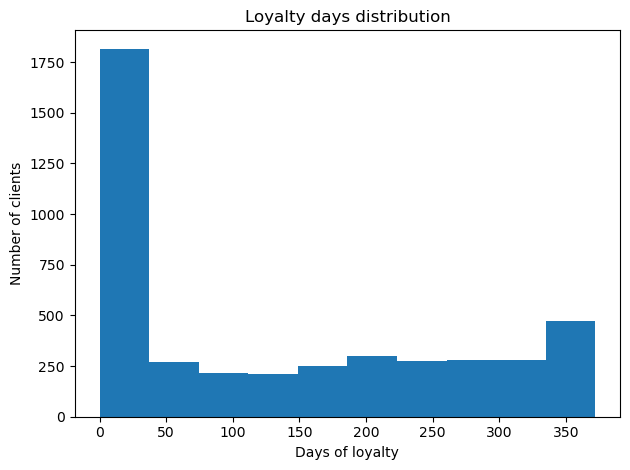

In [36]:
plt.hist(cust_data['loyalty_time'])
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.savefig("../visualizations/loyalty_distribution_cust_onlyonce.png")

### Excluding the once in a life time clients the distribution of loyalty days is shown below

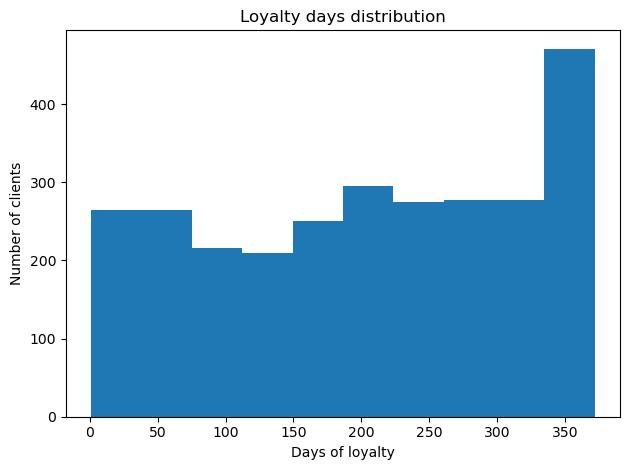

In [37]:
plt.hist(cust_data['loyalty_time'][cust_data.sort_values(by='loyalty_time', ascending=False)['loyalty_time']>0])
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.savefig("../visualizations/loyalty_distribution.png")

### I will perform a customer segmentation considering just the transactions without any return. Therefore, I will create two new datasets. The first one excluding the returned transactions and the second one with just the returned transactions.

In [38]:
# Grouping the data by customer and stock code to get the transactions with their returns
invoice_list = ot.groupby(['customer_id', 'stock_code']).agg({'invoice': list, 'quantity': 'sum'})
invoice_list = invoice_list[ot.groupby(['customer_id', 'stock_code'])['quantity'].sum() <= 0].reset_index()

In [39]:
invoice_idx = []
[invoice_idx.extend(ids) for ids in invoice_list['invoice']];

In [40]:
returns = ot[ot['invoice'].isin(invoice_idx)]

In [41]:
# Dataset without returns
online_trans = ot.drop(returns.index, axis=0).reset_index()

In [42]:
print(f"{round((ot.shape[0] - online_trans.shape[0]) * 100 / ot.shape[0], 2)} % are returns whose transaction were made in the time interval of the data")

7.56 % are returns whose transaction were made in the time interval of the data


In [43]:
# The negative values on the remaining data are considered return whose transactions were done outside the time interval of the data
retunr_wt_trans = online_trans[online_trans['quantity']<= 0]

### The negative values on the remaining data are considered return whose transactions were done outside the time interval of the data

In [44]:
print(f"{round(retunr_wt_trans.shape[0] * 100 / ot.shape[0], 2)}% are returns without quivalent transaction on the time interval of the data. These transactions are gonna be dropped from the data")

1.1% are returns without quivalent transaction on the time interval of the data. These transactions are gonna be dropped from the data


In [45]:
# Dropping returned data without transaction on the time interval of the dataframe
online_trans.drop(retunr_wt_trans.index, axis=0, inplace=True)

In [46]:
# Changing the name of the index column to stress that it is the index of the data with returns
online_trans.rename(columns={'index': 'old_index'}, inplace=True)

### The online_trans is gonna be the data that I will use for the customer segmentation analyis. Let's make an deep dive into the data to get to know it better

In [47]:
online_trans.describe()

,old_index,quantity,price,total_order_value,invoice_year,invoice_month,invoice_weekday
count,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000
mean,201388.280656,12.879829,2.905252,21.919158,2010.934356,7.650090,2.592034
std,115650.296643,43.577928,7.381186,95.735167,0.247660,3.405954,1.920402
min,0.000000,1.000000,0.001000,0.000000,2010.000000,1.000000,0.000000
25%,101119.750000,2.000000,1.250000,4.950000,2011.000000,5.000000,1.000000
50%,202424.500000,6.000000,1.950000,11.900000,2011.000000,8.000000,2.000000
75%,301284.250000,12.000000,3.750000,19.800000,2011.000000,11.000000,4.000000
max,399806.000000,4800.000000,1599.260000,38970.000000,2011.000000,12.000000,6.000000


In [48]:
online_trans[online_trans["total_order_value"] == 0]

,old_index,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,total_order_value,invoice_year,invoice_month,invoice_weekday,invoice_dayname
68994,75717,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,u13952,United Kingdom,0.0,2011,4,4,Friday
153656,168120,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 14:58:00,0.001,u16198,United Kingdom,0.0,2011,9,6,Sunday
273644,297370,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,u15618,United Kingdom,0.0,2011,7,1,Tuesday


### I will replace the total_order_value column coming from the reshift data base by the total order value calculated by myself and round it to 3 decimal points in order to avoid the zero entries that we see in the cell above

In [49]:
# Dropping 'total_order_value' columns
online_trans.drop('total_order_value', axis=1, inplace=True)

In [50]:
online_trans['total_order_value'] = online_trans['quantity'] * online_trans['price']

In [51]:
online_trans.describe()

,old_index,quantity,price,invoice_year,invoice_month,invoice_weekday,total_order_value
count,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000
mean,201388.280656,12.879829,2.905252,2010.934356,7.650090,2.592034,21.919158
std,115650.296643,43.577928,7.381186,0.247660,3.405954,1.920402,95.735167
min,0.000000,1.000000,0.001000,2010.000000,1.000000,0.000000,0.001000
25%,101119.750000,2.000000,1.250000,2011.000000,5.000000,1.000000,4.950000
50%,202424.500000,6.000000,1.950000,2011.000000,8.000000,2.000000,11.900000
75%,301284.250000,12.000000,3.750000,2011.000000,11.000000,4.000000,19.800000
max,399806.000000,4800.000000,1599.260000,2011.000000,12.000000,6.000000,38970.000000


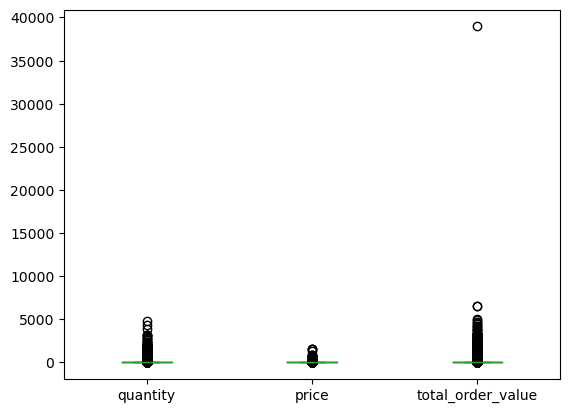

In [52]:
online_trans[["quantity", "price", "total_order_value"]].plot.box();

### We have clear outliers on our numerical variables. The will be normalized for the RFM analysis

In [53]:
online_trans.describe(include=object)

,invoice,stock_code,description,customer_id,country
count,365180,365180,365180,365180,365180
unique,17553,3634,3599,4247,37
top,576339,85123A,CREAM HANGING HEART T-LIGHT HOLDER,u17841,United Kingdom
freq,542,1909,1909,7499,326124


### The best seller item across all countries is "CREAM HANGING HEART T-LIGHT HOLDER". Most of the transactions are on United Kingdom. The best customer was "u17841" with a total of 7499 purchases. 

In [124]:
# Let's see the purchases from the best seller item. Country represents the country where the item was sale the most
agg_best_seller = {'quantity': 'sum', 'price': 'sum', 'country': lambda x: x.mode()[0]}
best_seller_table = online_trans.groupby(["stock_code"]).get_group("85123A").groupby('customer_id').agg(agg_best_seller)
best_seller_table

,quantity,price,country
customer_id,,,
u1237,94,5.50,Cyprus
u12391,10,2.95,Cyprus
u12409,32,2.55,Switzerland
u12428,6,2.95,Finland
u12455,32,2.55,Cyprus
...,...,...,...
u18248,6,2.95,United Kingdom
u18255,6,2.95,United Kingdom
u18257,6,2.95,United Kingdom


In [128]:
print(f"The best seller product was purchase for 824 customer on {best_seller_table['country'].nunique()} countries")

The best seller product was purchase for 824 customer on 15 countries


In [90]:
# Let's check the purchases from the best customer
agg_best_cust = {'quantity': 'sum', 'price': 'sum', 'total_order_value': 'sum'}
online_trans.groupby(["customer_id"]).get_group("u17841").groupby('stock_code').agg(agg_best_cust).sort_values(by='total_order_value')

,quantity,price,total_order_value
stock_code,,,
21983,1,0.29,0.29
84926A,1,0.29,0.29
22096,1,0.39,0.39
23551,1,0.39,0.39
85071A,1,0.39,0.39
...,...,...,...
22475,83,193.95,344.85
84078A,15,354.55,569.25
21686,17,274.65,629.15


### The best customer of the dataset bought in total 1305 different item  with the highest amount per invoice equal to 2754.80 pounds

## Let's explore now seasonality

In [129]:
# Getting the number of invoices per month and year
month_inv = online_trans.groupby(["invoice_year", "invoice_month"]).count()['invoice'].reset_index()

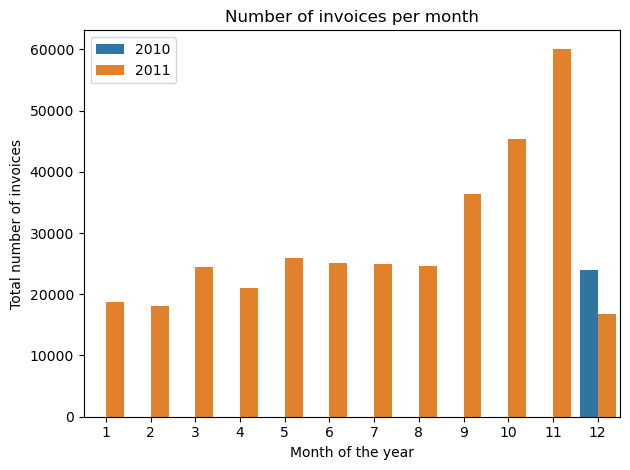

In [132]:
sns.barplot(data=month_inv, x='invoice_month', y='invoice', hue='invoice_year')
plt.title("Number of invoices per month")
plt.xlabel("Month of the year")
plt.ylabel("Total number of invoices")
plt.legend(loc='upper left')
plt.tight_layout();

In [60]:
# 1st and last order on the dataset
first_order = online_trans['invoice_date'].min()
last_order = online_trans['invoice_date'].max()
print(f"The first order on the dataset was purchase on {first_order} and the last one on {last_order}")

The first order on the dataset was purchase on 2010-12-01 08:26:00 and the last one on 2011-12-09 12:50:00


#### The number of invoices increases throughout the year, with a peak in November. The conclusions about December 2011 is incomplete because the dataset contains transactions till December 9th.

In [61]:
# Let's inspect the transactions on Dec 2010 and 2011 to have an estimation of the total sales on Dec 2011
Dec10_trans = online_trans[online_trans['invoice_date'] <= "2010-12-09 12:50:00"].groupby(["invoice_year", "invoice_month"]).count()['invoice'].reset_index()
Dec11_trans = online_trans[online_trans['invoice_date'] >= "2011-12-01 00:00:00"].groupby(["invoice_year", "invoice_month"]).count()['invoice'].reset_index()
Dec_comp = pd.concat([Dec10_trans, Dec11_trans])

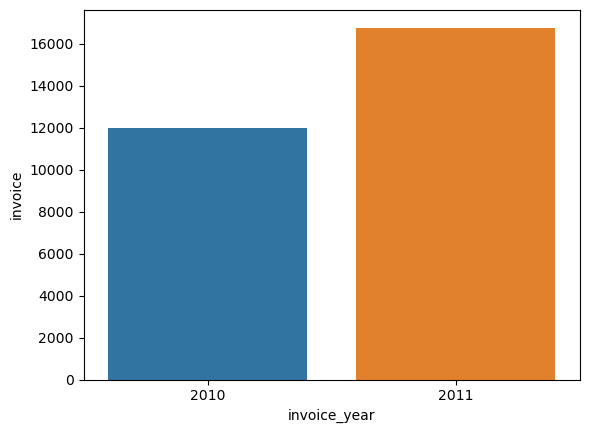

In [62]:
sns.barplot(data=Dec_comp, x='invoice_year', y='invoice');

#### The last data point recorded on December 2011 was on the 9th. In the previous plot I compare the number of invoices for that same day on 2010 and 2011. Eventhough the course of the invoice on December 2011 is inconclusive, it is clear that it surpassed the number of transactions on December 9th, 2010. we can expect that on Demcember 2011 sales are gonna be above than on Demcember 2010

### Let's check seasonality on a daily basis

In [143]:
# Getting the number of invoices per day of the week
daily_inv = online_trans.groupby(["invoice_weekday"]).count()['invoice'].reset_index()

In [171]:
# Getting the name of the day
weekday_names = online_trans['invoice_dayname'].unique().categories.tolist()
del weekday_names[-2] # deleting Saturday from the list

In [174]:
# adding the names to daily dataframe
daily_inv['invoice_dayname'] =  weekday_names

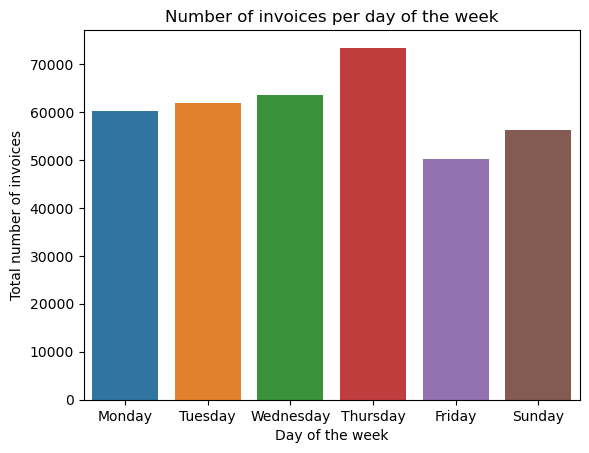

In [180]:
sns.barplot(data=daily_inv, x='invoice_dayname', y='invoice')
plt.title("Number of invoices per day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Total number of invoices");

### Thursday is the favorite day to shop for our customers.
<div class="alert alert-block alert-info">
<b>Note:</b> Data for Saturday is not available in this dataset.
</div>

In [212]:
# Frequency is the total transactions that they purchased

### Let's explore the average amount of items order per customer 

In [264]:
# number of stocks per customer per invoice
nstock_inv_cust = online_trans.groupby(["customer_id", "invoice"])['stock_code'].count()

In [305]:
# average stocks ordered by customer
mean_nstock_cust = nstock_inv_cust.groupby(level=0).mean()
print(f"The average stocks per customer per invoice is {round(mean_nitem_cust.mean())}")

The average stocks per customer per invoice is 22


In [309]:
# Let's add the average stock order per invoice per customer on my customer dataset
cust_data['mean_nstock'] = mean_nstock_cust

<div class="alert alert-block alert-info">
<b>Note:</b> There are some null values corresponding to the users that returned data. At the end of the analysis these customers are gonna be dropped
</div>

In [270]:
cust_data.isnull().sum()

loyalty_time      0
mean_nitem      115
mean_nstock     115
dtype: int64

In [263]:
online_trans.columns

Index(['old_index', 'invoice', 'stock_code', 'description', 'quantity',
       'invoice_date', 'price', 'customer_id', 'country', 'invoice_year',
       'invoice_month', 'invoice_weekday', 'invoice_dayname',
       'total_order_value'],
      dtype='object')

### Now explore the amount of items purchased by customer by invoice. This will represent the quantity of the previous stocks per invoice per client

In [304]:
# Amount of items order per invoice by customer
nitem_inv_cust = online_trans.groupby(["customer_id", "invoice"])['quantity'].sum() #.agg({'quantity': 'sum', 'total_order_value': 'sum'})

In [306]:
# Average amount of items order by customer
mean_nitem_cust = nitem_inv_cust.groupby(level=0).mean()
print(f"The average items per customer per invoice is {round(mean_nitem_cust.mean())}")

The average items per customer per invoice is 225


In [310]:
# Let's add the average amount of items per invoice per customer on my customer dataset
cust_data['mean_nitem'] = mean_nitem_cust

In [311]:
cust_data

,loyalty_time,mean_nitem,mean_nstock
customer_id,,,
u12346,0,NaN,NaN
u12347,365,351.142857,26.000000
u12348,282,583.000000,6.750000
u12349,0,630.000000,72.000000
u1235,0,196.000000,16.000000
...,...,...,...
u1828,0,45.000000,10.000000
u18281,0,54.000000,7.000000
u18282,118,51.500000,6.000000
